# Nucleosome Positioning Analysis

This notebook calculates nucleosome positions and occupancy using energy-based models.

In [238]:
import re
import numpy as np
from scipy.special import erf
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm

## Function Definitions

Core functions for nucleosome positioning calculations.

In [239]:
FOOTPRINT = 147
SMOOTH_WINDOW = 10
OCCUPANCY_KERNEL = 146

_ASCII_TO_IDX = np.full(256, -1, dtype=np.int8)
_ASCII_TO_IDX[ord("A")] = 0
_ASCII_TO_IDX[ord("C")] = 1
_ASCII_TO_IDX[ord("G")] = 2
_ASCII_TO_IDX[ord("T")] = 3


@dataclass(frozen=True)
class NucPositionResult:
    energy: np.ndarray
    dyad_probability: np.ndarray
    occupancy: np.ndarray


def clean_sequence(dna: str) -> str:
    """Remove non-GATC characters to prevent energy calculation errors."""
    dna = dna.upper().replace("U", "T")
    return re.sub(r"[^GATC]", "", dna)


def encode_seq(seq: str) -> np.ndarray:
    """Convert to numeric indices for vectorized computation."""
    b = np.frombuffer(seq.encode("ascii"), dtype=np.uint8)
    return _ASCII_TO_IDX[b]


def getweight(w: int, p: float, b: float) -> np.ndarray:
    """Generate position-dependent dinucleotide weights to model DNA bendability."""
    x = np.arange(w, dtype=np.float64)
    s = b * np.sin(2 * np.pi * x / p)
    weights = np.empty((4, 4, w), dtype=np.float64)
    weights[0, 0] = 0.25 + s
    weights[0, 1] = 0.25 - s / 3
    weights[0, 2] = 0.25 - s / 3
    weights[0, 3] = 0.25 - s / 3
    weights[1, 0] = 0.25
    weights[1, 1] = 0.25
    weights[1, 2] = 0.25
    weights[1, 3] = 0.25
    weights[2, 0] = 0.25 + s / 3
    weights[2, 1] = 0.25 - s
    weights[2, 2] = 0.25 + s / 3
    weights[2, 3] = 0.25 + s / 3
    weights[3, 0] = 0.25 + s
    weights[3, 1] = 0.25 - s
    weights[3, 2] = 0.25 - s
    weights[3, 3] = 0.25 + s
    return weights


def calculate_energy(seq: str, w: int, amplitude: float, period: float) -> np.ndarray:
    """Compute energy landscape by accounting for both forward and reverse strand binding."""
    idx = encode_seq(seq)
    L = idx.size
    num_win = L - w
    if num_win <= 0:
        return np.array([], dtype=np.float64)
    weights = getweight(w, period, amplitude)
    log_weights = np.log(np.clip(weights, 1e-300, None))
    log_p_f = np.zeros(num_win, dtype=np.float64)
    log_p_r = np.zeros(num_win, dtype=np.float64)
    i = np.arange(num_win)
    for s in range(w):
        if s > 0:
            prev_f = idx[i + s - 1]
        else:
            prev_f = idx[i + s]
        curr_f = idx[i + s]
        log_p_f += log_weights[prev_f, curr_f, s]
        a = idx[i + w - s]
        b = idx[i + w - s - 1]
        rprev = 3 - a
        rcurr = 3 - b
        log_p_r += log_weights[rprev, rcurr, s]
    p_f = np.exp(log_p_f) * (4.0**w)
    p_r = np.exp(log_p_r) * (4.0**w)
    p_r = np.roll(p_r, -1)
    E = (p_r * np.log(p_r) + p_f * np.log(p_f)) / (p_r + p_f)
    return E


def vanderlick(Energy: np.ndarray, mu: float, footprint: int) -> np.ndarray:
    """Compute equilibrium dyad probability accounting for steric exclusion between nucleosomes."""
    E_out = Energy - mu
    n = E_out.size
    forward = np.zeros(n, dtype=np.float64)
    sum_prev = 0.0
    for i in range(n):
        forward[i] = np.exp(E_out[i] - sum_prev)
        sum_prev += forward[i]
        if i >= footprint:
            sum_prev -= forward[i - footprint]
    backward = np.zeros(n, dtype=np.float64)
    r_forward = forward[::-1]
    sum_prod = 0.0
    for i in range(n):
        backward[i] = 1.0 - sum_prod
        sum_prod += r_forward[i] * backward[i]
        if i >= footprint:
            sum_prod -= r_forward[i - footprint] * backward[i - footprint]
    return forward * backward[::-1]


def CalcNucPositions(
    sequence: str, w: int, chemical_potential: float, amplitude: float, period: float
) -> NucPositionResult:
    """Pipeline combining all steps to generate final nucleosome positioning prediction."""
    sequence = clean_sequence(sequence)
    energy = calculate_energy(sequence, w, amplitude, period)
    dyad_probability = vanderlick(energy, chemical_potential, w)
    left_pad = (w + 1) // 2
    right_pad = w // 2
    dyad_probability = np.concatenate(
        (
            np.zeros(left_pad, dtype=np.float64),
            dyad_probability,
            np.zeros(right_pad, dtype=np.float64),
        )
    )
    dyad_probability = np.clip(dyad_probability,0,1)
    occupancy = np.convolve(
        dyad_probability, np.ones(OCCUPANCY_KERNEL, dtype=np.float64), mode="same"
    )
    occupancy = np.clip(occupancy, 0, 1)
    return NucPositionResult(energy, dyad_probability, occupancy)


def create_sequence(contour_length, dyads_601=None):
    """Generate test sequences with known positioning elements for validation."""
    sequence = np.random.choice(list("ACGT"), contour_length)

    if dyads_601 is not None:
        sequence_601 = list(
            "ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG"
        )
        for dyad in dyads_601:
            start_index = max(0, dyad - len(sequence_601) // 2)
            end_index = min(contour_length, dyad + len(sequence_601) // 2)
            length = end_index - start_index
            sequence[start_index : start_index + length] = sequence_601[:length]

    sequence = "".join(sequence)
    return sequence


def sample_fiber_configuration(dyad_probability: np.ndarray, footprint: int = FOOTPRINT) -> np.ndarray:
    """
    Stochastically sample a single nucleosome arrangement to generate ensemble statistics.
    Edge regions are excluded to prevent boundary artifacts from biasing occupancy.
    """
    p = dyad_probability.copy()
    nucs = np.zeros_like(dyad_probability)
    dyads = []
    
    
    num_nucleosomes = np.floor(np.sum(dyad_probability)) + np.random.binomial(1, np.sum(dyad_probability) % 1)
    half_footprint = footprint // 2
    seq_length = len(dyad_probability)

    for _ in range(int(num_nucleosomes)):
        # Sample a dyad position
        dyads.append(np.random.choice(seq_length, p=p/p.sum()))
        
        nuc_start = dyads[-1] - half_footprint
        nuc_end = nuc_start + footprint
        
        nucs[nuc_start:nuc_end] = 1
        p[nuc_start:nuc_end] = 0

    return dyads, nucs

def calc_methylation(sequence, dyads, sigma=15, efficiency = 0.85):
    dyads = np.array(dyads)
    footprint = FOOTPRINT - 2*sigma
    unprotected = [np.prod(0.5 * (1 + erf((np.abs(dyads - i) - footprint/2) / (sigma * np.sqrt(2))))) for i in range(len(sequence))]
    targets = np.array([1 if base in 'AT' else 0 for base in sequence])
    methylated = np.random.binomial(1, unprotected * targets * efficiency)
    return methylated

def plot_results(dyads = None, dyad_probability = None, occupancy = None, nucs = None, methylation = None):
    """Visualize multiple layers of positioning data for comparison."""
    plt.figure(figsize=(15, 2.5))
    xmax = 0
    if dyads is not None:
        plt.vlines(dyads, 0, 1.5, colors="grey", linestyles="dashed", label="601 Dyads", alpha=0.5)
    if dyad_probability is not None:
        plt.plot(dyad_probability * 1e1, label="Dyads", color="red")
        xmax = len(dyad_probability)
    if occupancy is not None:
        plt.plot(occupancy, label="Occupancy", color="blue")
        xmax = len(occupancy)
    if nucs is not None:
        x = np.arange(len(nucs))
        plt.fill_between(x, 0, nucs, alpha=0.1, color="blue", label="Nucleosomes")
        xmax = len(nucs)
    if methylation is not None:
        x = np.arange(len(methylation))
        plt.scatter(x[methylation == 1], 0.5* methylation[methylation == 1], marker='o', alpha=0.3,
                    facecolors='none', edgecolors="green", linewidths=0.5, color='green', label='Methylation')
        xmax = len(methylation)
        
    plt.xlabel("i (bp)")
    plt.ylabel("Probability")
    plt.legend(loc="lower right", framealpha=1, facecolor='white')
    plt.ylim(-0.1, 1.1)
    plt.xlim(0,xmax)
    plt.tight_layout()
    # plt.show()

## Generate Test Sequence

Create a random DNA sequence with optional 601 positioning sequences embedded at specific positions.

In [240]:
contour_length = 10000

# Optionally add 601 sequences
handle_length = 3000
dyads_601 = np.arange(handle_length, contour_length - handle_length, 197)

## Visualize Results

Plot the dyad probability and nucleosome occupancy with vertical lines showing the 601 dyad positions.

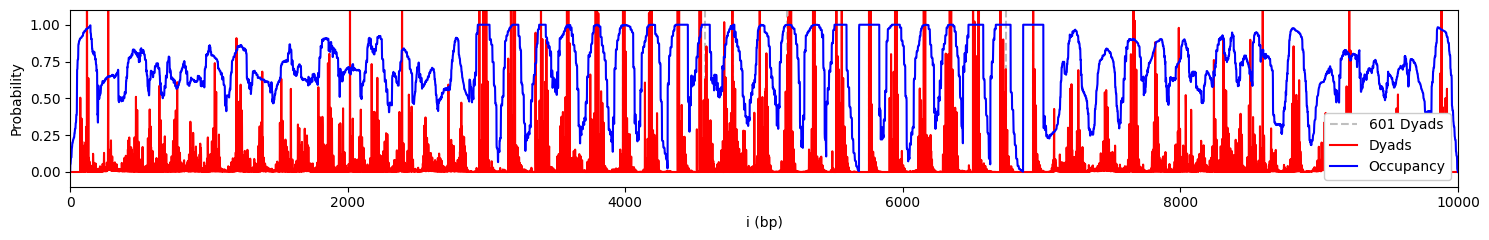

In [241]:
# dyads_601 =[]
sequence = create_sequence(contour_length, dyads_601)
result = CalcNucPositions(
    sequence, 
    FOOTPRINT, 
    chemical_potential=1.5, 
    amplitude=0.11, 
    period=9.8
)

plot_results(dyads=dyads_601, dyad_probability=result.dyad_probability, occupancy=result.occupancy)


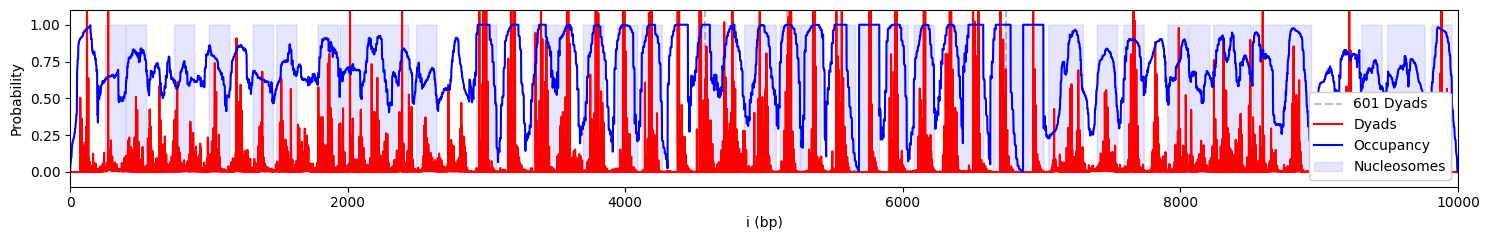

In [243]:
fiber_dyads, fiber_nucs = sample_fiber_configuration(result.dyad_probability, FOOTPRINT)

plot_results(dyads=dyads_601, dyad_probability=result.dyad_probability, occupancy=result.occupancy, nucs=fiber_nucs)


100%|██████████| 1000/1000 [00:08<00:00, 116.77it/s]


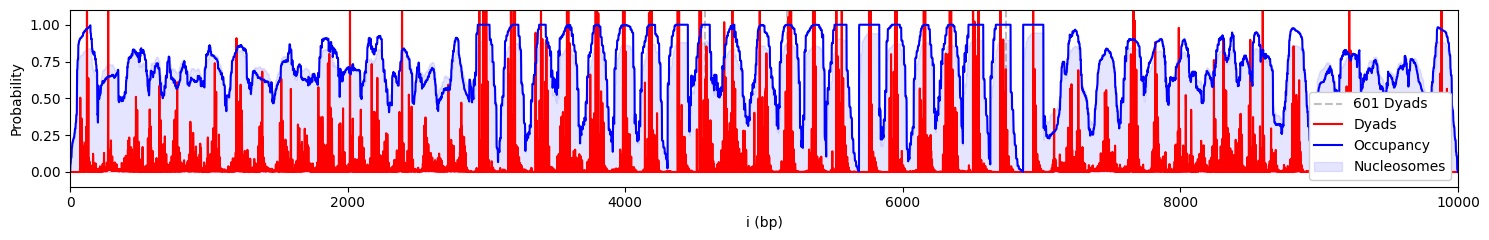

In [244]:
nucs = np.zeros_like(result.dyad_probability)

n = 1000
for _ in tqdm(range(n)):
    nucs += sample_fiber_configuration(result.dyad_probability, FOOTPRINT)[-1]
nucs /= n

plot_results(dyads=dyads_601, dyad_probability=result.dyad_probability, occupancy=result.occupancy, nucs=nucs)